In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [27]:
LABELS = ["Normal","Fraud"]
sns.set(style='white', font_scale=1.45)
sns.set_palette(sns.color_palette("Set2"))

In [5]:
df = pd.read_csv("creditcard.csv")
df.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [7]:
df.columns[df.isnull().any()].tolist()

[]

In [8]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

Conjunto de dados altamente desbalanceado (classe negativa predominante).

## Exploração dos Dados:

In [9]:
df_normal = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]

In [11]:
df_normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [12]:
df_fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

### Visualização dos dados:

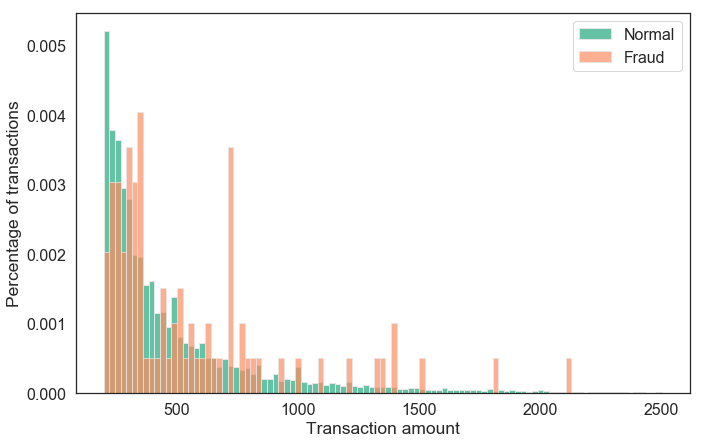

In [13]:
bins = np.linspace(200, 2500, 100)
plt.figure(figsize=(11,7))
plt.hist(df_normal['Amount'], bins, alpha = 1, density=True, edgecolor='#E6E6E6', label='Normal')
plt.hist(df_fraud['Amount'], bins, alpha = 0.7, density=True, edgecolor='#E6E6E6', label='Fraud')
plt.legend(loc='upper right')
plt.xlabel("Transaction amount")
plt.ylabel("Percentage of transactions");
plt.show()

As fraudes variam bastante entre os valores das transações, e também são poucas as transações classificadas como fraudes; logo seria muito difícil conseguir classificar uma transação como fraude utilizando apenas o valor da mesma.

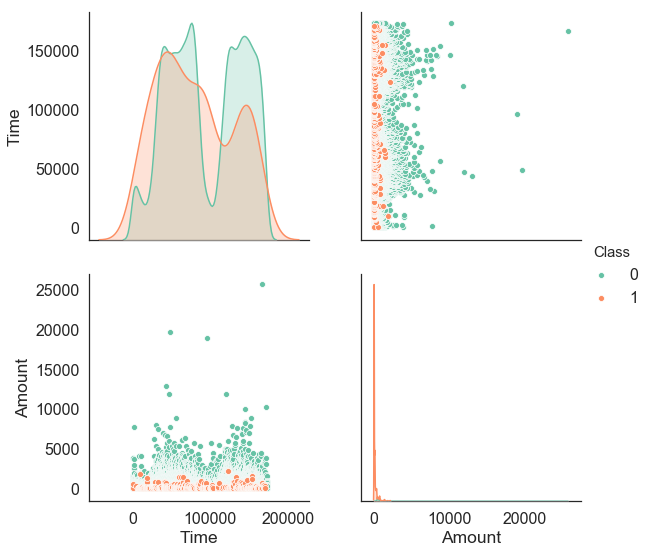

In [7]:
sns.pairplot(df, hue='Class',  vars=['Time', 'Amount'], height=4)

Visualizando o gráfico de Time x Amount, podemos apenas concluir que as transações classificadas como fraude possuem um limite, aproximadamente de U$ 2500,00, porém ainda é difícil tentar separar separar esses dados utilizando um classificador que possua apenas essas informações.

Assim como feito anteriormente, podemos visualizar a densidade de transações baseadas pelo tempo em horas;

In [27]:
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

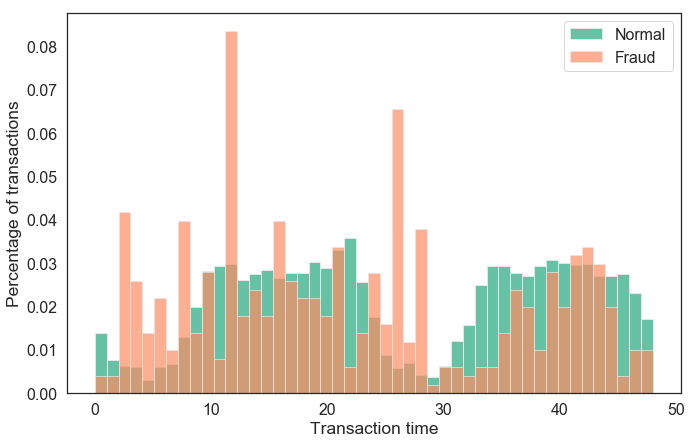

In [28]:
# Como o valor máximo é de aproximadamente 48 horas então fazemos o bin entre 0 e 48 
bins = np.linspace(0, 48, 48)
plt.figure(figsize=(11,7))

#Tempo em segundos no dataset
plt.hist(df_normal['Time']/(60*60), bins, alpha = 1, density=True, edgecolor='#E6E6E6', label='Normal')
plt.hist(df_fraud['Time']/(60*60), bins, alpha = 0.7, density=True, edgecolor='#E6E6E6', label='Fraud')
plt.legend(loc='upper right')
plt.xlabel("Transaction time")
plt.ylabel("Percentage of transactions");
plt.show()

* A variável Time do conjunto é definida como: Number of seconds elapsed between this transaction and the first transaction in the dataset. Logo, tempo 0 não significa aqui 24hs. 
    
* É possível visualizar que as fraudes crescem em momentos que a densidade de transações normais normais e baixa e começa a sofrer mais quedas, como por exemplo nos tempos de 2 a 4 e de 24 a 29.

## Construção do Modelo

* Devemos considerar que o conjunto de dados é extremamente desbalanceado, por isso utilizaremos algumas técnicas implementadas na biblioteca imblearn com o objetivo de alcançar melhores resultados;
* Técnica de over-sampling (SMOTE);
* Criação de amostras artificias utilizando os k-vizinhos-mais-próximos das amostras da classe minoritária (transações fraudulentas);
* Randomicamente escolhe um desses vizinhos para criar novas amostras similares; 

In [10]:
X = df.drop(['Class'], axis=1)
y = df['Class'] 

In [11]:
smt = SMOTE(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

In [12]:
pd.value_counts(y_resampled)

1    284315
0    284315
dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

C:\Users\pedro\Anaconda3\envs\iris\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Avaliação do Modelo

In [21]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    '''
    imprime a acurácia, o relatório de classificação e a matrix de confusão do classificador
    '''
    if train:
        '''
        Avaliação do treinamento
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Cross Validation Result: \n")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Std Accuracy: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        Avaliação do teste
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))   

In [22]:
print_score(rf_clf, X_train, y_train, X_test, y_test)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    198976
           1       1.00      1.00      1.00    199065

   micro avg       1.00      1.00      1.00    398041
   macro avg       1.00      1.00      1.00    398041
weighted avg       1.00      1.00      1.00    398041


Confusion Matrix: 
 [[198974      2]
 [     0 199065]]

Cross Validation Result: 

Average Accuracy: 	 0.9998
Std Accuracy: 		 0.0001


In [20]:
print_score(rf_clf, X_train, y_train, X_test, y_test, False)

Test Result:

accuracy score: 0.9999

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85339
           1       1.00      1.00      1.00     85250

   micro avg       1.00      1.00      1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589


Confusion Matrix: 
 [[85322    17]
 [    5 85245]]



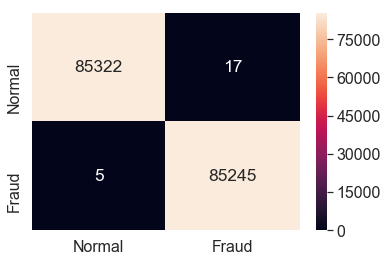

In [30]:
conf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

Para o teste obtivemos excelentes resultados presição e revocação, além de poucos falsos positivos, que seria aqui um dos maiores problemas, pois resultaria em:
* Perda de clientes dada as classificações incorretas de transações como fraudes;
* Aumento de custos para a empresa;
* Entre outros;